# Multibin Coupled HistoSys

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import logging
import json

import pyhf
from pyhf import Model

logging.basicConfig(level = logging.INFO)

In [3]:
def prep_data(sourcedata):
    spec =  {
        'channels': [
            {
                'name': 'signal',
                'samples': [
                    {
                        'name': 'signal',
                        'data': sourcedata['signal']['bindata']['sig'],
                        'modifiers': [
                            {
                                'name': 'mu',
                                'type': 'normfactor',
                                'data': None
                            }
                        ]
                    },
                    {
                        'name': 'bkg1',
                        'data': sourcedata['signal']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['signal']['bindata']['bkg1_dn'], 'hi_data': sourcedata['signal']['bindata']['bkg1_up']}
                            }
                        ]
                    },
                    {
                        'name': 'bkg2',
                        'data': sourcedata['signal']['bindata']['bkg2'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['signal']['bindata']['bkg2_dn'], 'hi_data': sourcedata['signal']['bindata']['bkg2_up']}
                            }
                        ]
                    }
                ]
            },
            {
                'name': 'control',
                'samples': [
                    {
                        'name': 'background',
                        'data': sourcedata['control']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['control']['bindata']['bkg1_dn'], 'hi_data': sourcedata['control']['bindata']['bkg1_up']}
                            }
                        ]
                    }
                ]
            }
        ]
    }
    pdf  = Model(spec)
    data = []
    for c in pdf.spec['channels']:
        data += sourcedata[c['name']]['bindata']['data']
    data = data + pdf.config.auxdata
    return data, pdf

In [4]:
validation_datadir = '../../validation/data'

In [5]:
source = json.load(open(validation_datadir + '/2bin_2channel_coupledhisto.json'))

data, pdf = prep_data(source['channels'])

print(data)

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

unconpars = pyhf.optimizer.unconstrained_bestfit(pyhf.utils.loglambdav, data, pdf, init_pars, par_bounds)
print('parameters post unconstrained fit: {}'.format(unconpars))

conpars = pyhf.optimizer.constrained_bestfit(pyhf.utils.loglambdav, 0.0, data, pdf, init_pars, par_bounds)
print('parameters post constrained fit: {}'.format(conpars))

pdf.expected_data(conpars)

INFO:pyhf.pdf:Validating spec against schema: /home/jovyan/pyhf/pyhf/data/spec.json
INFO:pyhf.pdf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier coupled_histosys (1 new nuisance parameters)


[170.0, 220.0, 110.0, 105.0, 0.0]
parameters post unconstrained fit: [1.05563069e-12 4.00000334e+00]
parameters post constrained fit: [0.         4.00000146]


array([ 1.25000007e+02,  1.60000022e+02,  2.10000022e+02, -8.00631284e-05,
        4.00000146e+00])

INFO:pyhf.pdf:Validating spec against schema: /home/jovyan/pyhf/pyhf/data/spec.json
INFO:pyhf.pdf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier coupled_histosys (1 new nuisance parameters)


[170.0, 220.0, 110.0, 105.0, 0.0]
parameters post unconstrained fit: [1.05563069e-12 4.00000334e+00]
parameters post constrained fit: [0.         4.00000146]




{'exp': [0.37566312243018246,
  0.49824494455027707,
  0.7023047842202288,
  0.9869744452422563,
  1.3443167343146392],
 'obs': 0.329179494864517}

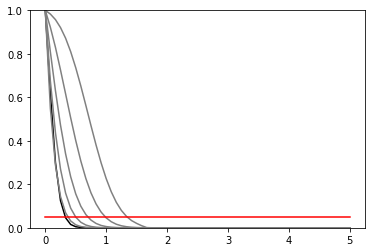

In [6]:
def plot_results(test_mus, cls_obs, cls_exp, poi_tests, test_size = 0.05):
    plt.plot(poi_tests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(poi_tests, cls_exp[i], c = c)
    plt.plot(poi_tests,[test_size]*len(test_mus), c = 'r')
    plt.ylim(0,1)

def invert_interval(test_mus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size,
                                             list(reversed(yvals)),
                                             list(reversed(test_mus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,
                                    list(reversed(yvals)),
                                    list(reversed(test_mus)))
    return point05cross


poi_tests = np.linspace(0, 5, 61)
tests = [pyhf.utils.hypotest(poi_test, data, pdf, init_pars, par_bounds, return_expected_set=True) 
         for poi_test in poi_tests]
cls_obs = np.array([test[0] for test in tests]).flatten()
cls_exp = [np.array([test[1][i] for test in tests]).flatten() for i in range(5)]

print('\n')
plot_results(poi_tests, cls_obs, cls_exp, poi_tests)
invert_interval(poi_tests, cls_obs, cls_exp)